In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/GitHub

/content/drive/MyDrive/GitHub


In [4]:
%cd 'soil-physics-theory'

/content/drive/MyDrive/GitHub/soil-physics-theory


In [5]:
%cd 'content/chapter-4'

/content/drive/MyDrive/GitHub/soil-physics-theory/content/chapter-4


Import Library

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import *

4.1

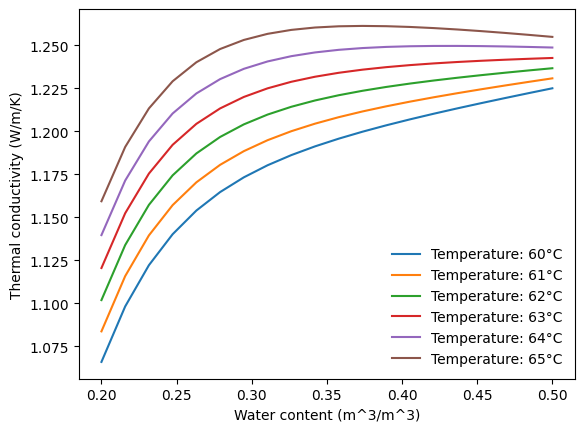

In [ ]:

# Define parameters
from PSP_heatSoil import thermalConductivity
bulkDensity = 1100  # kg/m^3
clay = 0.250  # clay content of soil (g/g)
waterContents = np.linspace(0.2, 0.5, 20)  # Vary water content from 30% to 50%
temperatures = range(60, 66, 1)  # Temperature range from 63°C to 66°C

# Calculate thermal conductivity for each temperature and water content
thermal_conductivities = []
for temp in temperatures:
    conductivity_at_temp = []
    for water_content in waterContents:
        conductivity_at_temp.append(thermalConductivity(bulkDensity, water_content, clay, temp))
    thermal_conductivities.append(conductivity_at_temp)

# Plotting
for i, temp in enumerate(temperatures):
    plt.plot(waterContents, thermal_conductivities[i], label=f'Temperature: {temp}°C')

plt.xlabel('Water content (m^3/m^3)')
plt.ylabel('Thermal conductivity (W/m/K)')
plt.legend(fontsize='8')
plt.legend(frameon=False)
plt.grid(False)
plt.show()

4.2

In [ ]:
from PSP_heatSoil import heatCapacity
bulkDensity = 950 # kg m^-3
waterContent = 0.00 # m^3 m^-3
C_h = heatCapacity(bulkDensity, waterContent)
print("The minimum heat capacity is approximately " + f'{C_h/10**6:.3f}' + " MJ/m^3/K.")


The minimum heat capacity is approximately 0.860 MJ/m^3/K.


The minimum value will occur when bulk density and soil water content are at their minimum values, which for mineral soils could be a bulk density of 950 kg m −3 and soil water content of 0.00 m 3 m −3 .

In [ ]:
bulkDensity = 950 # kg m^-3
porosity = 1 - bulkDensity/2650 # m^3 m^-3
waterContent = porosity # m^3 m^-3
C_h = heatCapacity(bulkDensity, waterContent)
print("The maximum heat capacity is approximately " + f'{C_h/10**6:.3f}' + " MJ/m^3/K.")

The maximum heat capacity is approximately 3.542 MJ/m^3/K.


The maximum value will occur when bulk density is minimum and soil water content is maximum, which for mineral soils could be a bulk density of 950 kg m −3 and soil water content equal to the porosity

4.3

1 Finite Difference
2 Cell-Centered Finite Volume
Select solver: 1
Uniform water content (1) or variable water content with depth (2)?1
water content (m^3/m^3): 0.35
mean temperature [C]: 25
amplitude of change in temperature [C]: 10
weighting factor for time discretization: (0: explicit, 1: implicit Euler) = 0.6
nr of simulation hours: 72
nr of iterations per hour: 1.0416666666666667


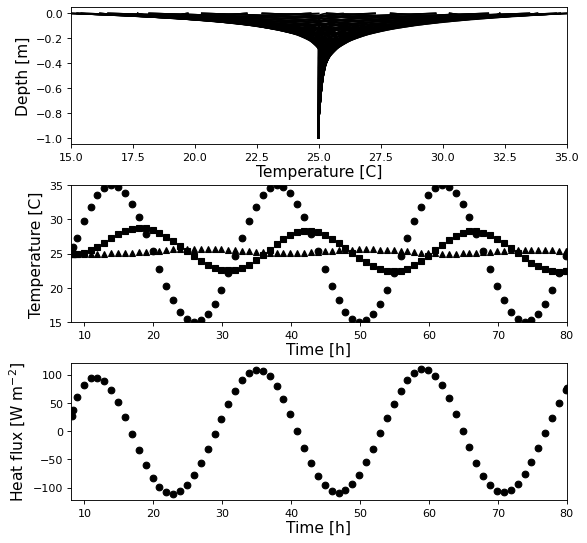

In [ ]:
from main2 import main
bulkDensity = 1000 # kg m^-3
clay = 0.4
main()

4.4

1 Finite Difference
2 Cell-Centered Finite Volume
Select solver: 1
Uniform water content (1) or variable water content with depth (2)?1
water content (m^3/m^3): 0.1
mean temperature [C]: 25
amplitude of change in temperature [C]: 10
weighting factor for time discretization: (0: explicit, 1: implicit Euler) = 0.6
nr of simulation hours: 72
nr of iterations per hour: 1.0416666666666667


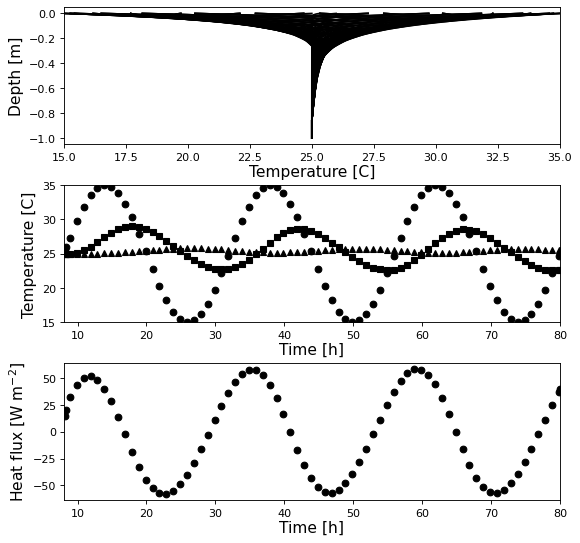

In [ ]:
bulkDensity = 1000 # kg m^-3
clay = 0.4
main()

1 Finite Difference
2 Cell-Centered Finite Volume
Select solver: 1
Uniform water content (1) or variable water content with depth (2)?2
surface water content (m^3/m^3): 0
sub-surface water content (m^3/m^3): 0.35
mean temperature [C]: 25
amplitude of change in temperature [C]: 10
weighting factor for time discretization: (0: explicit, 1: implicit Euler) = 0.6
nr of simulation hours: 72
nr of iterations per hour: 1.0416666666666667


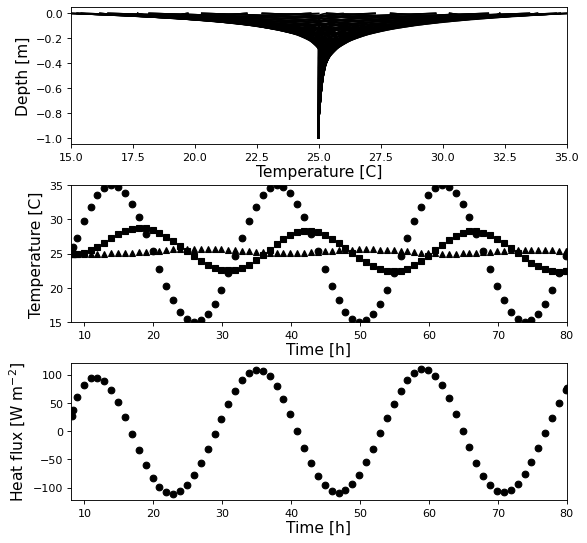

In [ ]:
bulkDensity = 1000 # kg m^-3
clay = 0.4
main()

4.5

1 Finite Difference
2 Cell-Centered Finite Volume
Select solver: 1
Uniform water content (1) or variable water content with depth (2)?1
water content (m^3/m^3): 0.35
mean temperature [C]: 25
amplitude of change in temperature [C]: 10
weighting factor for time discretization: (0: explicit, 1: implicit Euler) = 0.6
nr of simulation hours: 72
time [hr], T @ 0.15 m, T @ 0.30 m,

8.125,25.000,25.000,

8.375,25.000,25.000,

8.875,25.003,25.000,

9.875,25.055,25.000,

10.875,25.206,25.002,

11.875,25.474,25.007,

12.875,25.846,25.020,

13.875,26.286,25.044,

14.875,26.746,25.082,

15.875,27.180,25.136,

16.875,27.544,25.207,

17.875,27.800,25.291,

18.875,27.924,25.386,

19.875,27.906,25.485,

20.875,27.746,25.582,

21.875,27.456,25.670,

22.875,27.058,25.744,

23.875,26.576,25.798,

24.875,26.041,25.829,

25.875,25.484,25.835,

26.875,24.936,25.817,

27.875,24.429,25.774,

28.875,23.990,25.711,

29.875,23.645,25.630,

30.875,23.416,25.536,

31.875,23.318,25.435,

32.875,23.363,25.333,

33.87

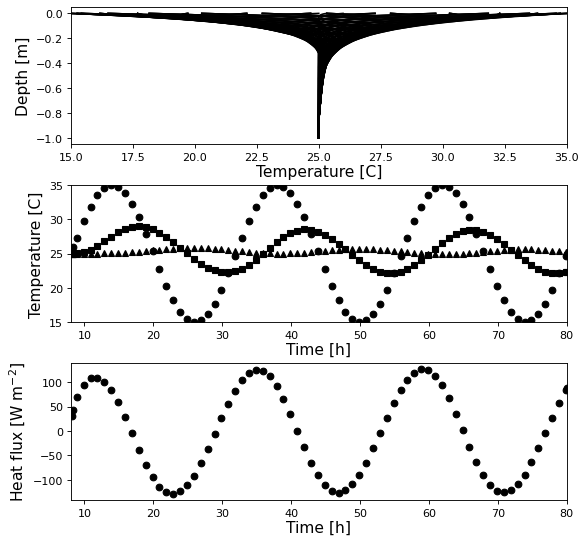

In [15]:
from main3_cole import main
bulkDensity = 1000 # kg m^-3
clay = 0.4
main(bulkDensity,clay)

4.6

In [ ]:
from PSP_soil import *
Db= [1500,900]
clay= [0.1,0.3,0.7]
theta = 0.3
temp = 25

for i in Db:
    for j in clay:
        K = thermalConductivity(i, theta, j, temp)
        print('bulk density = ', i, ' clay = ', j, ' conductivity = ', K)


bulk density =  1500  clay =  0.1  conductivity =  1.1905622999739145
bulk density =  1500  clay =  0.3  conductivity =  1.1862159732171547
bulk density =  1500  clay =  0.7  conductivity =  1.1213825252006733
bulk density =  900  clay =  0.1  conductivity =  0.6278320949527835
bulk density =  900  clay =  0.3  conductivity =  0.621795424005874
bulk density =  900  clay =  0.7  conductivity =  0.5352751195379998


Using 0% clay and bulk density 1500 kg/m^3 for sandy soil

1 Finite Difference
2 Cell-Centered Finite Volume
Select solver: 1
Uniform water content (1) or variable water content with depth (2)?1
water content (m^3/m^3): 0.3
mean temperature [C]: 20
amplitude of change in temperature [C]: 10
weighting factor for time discretization: (0: explicit, 1: implicit Euler) = 0.6
nr of simulation hours: 48
nr of iterations per hour: 1.0625


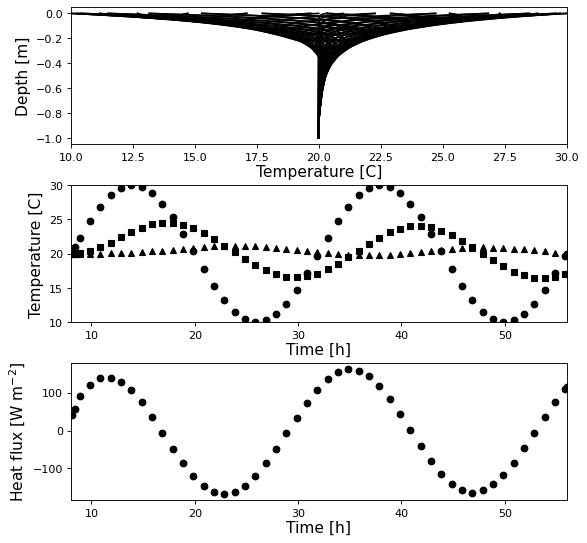

In [7]:
bulkDensity = 1500. # kg/m3
clay = 0.00 # g/g
from main2 import main
main(bulkDensity, clay)

For silt loam soil with 10% clay

1 Finite Difference
2 Cell-Centered Finite Volume
Select solver: 1
Uniform water content (1) or variable water content with depth (2)?1
water content (m^3/m^3): 0.3
mean temperature [C]: 20
amplitude of change in temperature [C]: 10
weighting factor for time discretization: (0: explicit, 1: implicit Euler) = 0.6
nr of simulation hours: 48
nr of iterations per hour: 1.0625


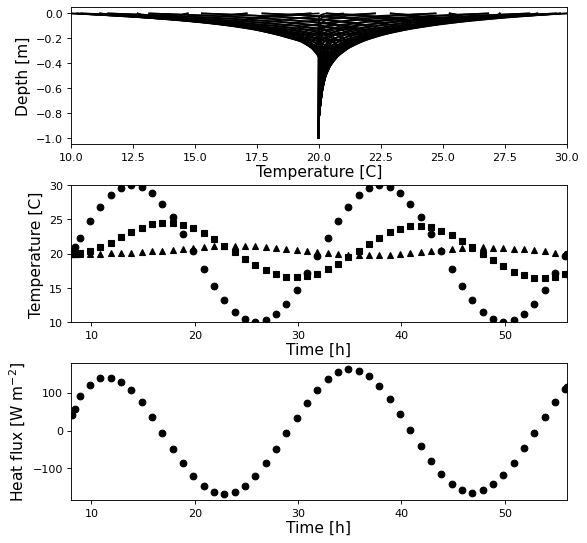

In [8]:
bulkDensity = 1500. # kg/m3
clay = 0.1 # g/g
from main2 import main
main(bulkDensity, clay)

For clay soil with 60% clay and 1500 bulk density

1 Finite Difference
2 Cell-Centered Finite Volume
Select solver: 1
Uniform water content (1) or variable water content with depth (2)?1
water content (m^3/m^3): 0.3
mean temperature [C]: 20
amplitude of change in temperature [C]: 10
weighting factor for time discretization: (0: explicit, 1: implicit Euler) = 0.6
nr of simulation hours: 48
nr of iterations per hour: 1.0625


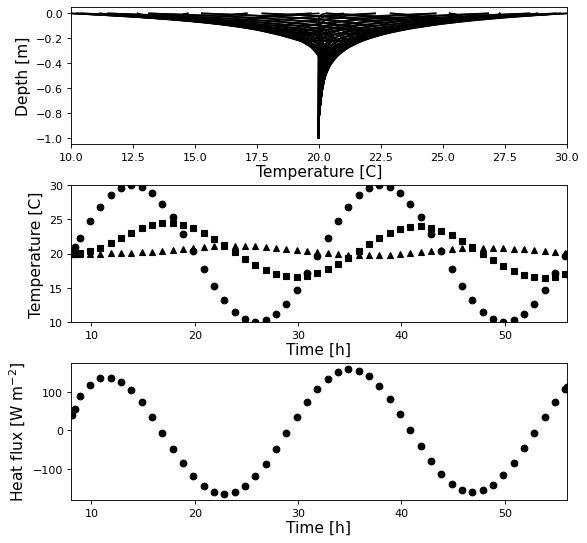

In [9]:
bulkDensity = 1500. # kg/m3
clay = 0.6 # g/g
from main2 import main
main(bulkDensity, clay)

For tilled soil with bulk density 900 kg/m^3 and sandy soil with 0% clay

1 Finite Difference
2 Cell-Centered Finite Volume
Select solver: 1
Uniform water content (1) or variable water content with depth (2)?1
water content (m^3/m^3): 0.3
mean temperature [C]: 20
amplitude of change in temperature [C]: 10
weighting factor for time discretization: (0: explicit, 1: implicit Euler) = 0.6
nr of simulation hours: 48
nr of iterations per hour: 1.0625


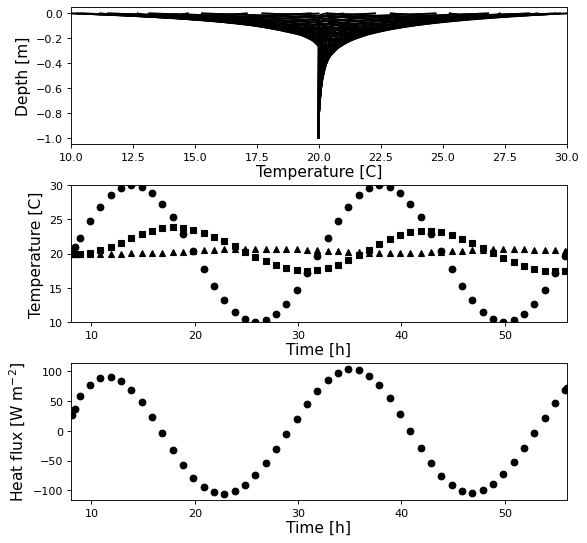

In [11]:
bulkDensity = 900. # kg/m3
clay = 0.0 # g/g
from main2 import main
main(bulkDensity, clay)

4.7

1 Finite Difference
2 Cell-Centered Finite Volume
Select solver: 1
Uniform water content (1) or variable water content with depth (2)?1
water content (m^3/m^3): 0.2
mean temperature [C]: 25
amplitude of change in temperature [C]: 10
weighting factor for time discretization: (0: explicit, 1: implicit Euler) = 1
nr of simulation hours: 72
nr of iterations per hour: 1.0416666666666667


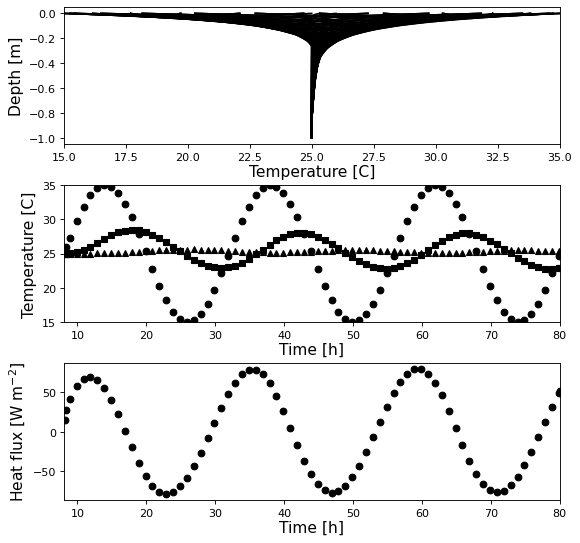

In [12]:
from main2 import main
bulkDensity = 900. # kg/m3
clay = 0.4 # g/g
main(bulkDensity, clay)
#implicit Euler weighting factor=1

When used Explicit= 0 gives dt= 1 no convergence

1 Finite Difference
2 Cell-Centered Finite Volume
Select solver: 1
Uniform water content (1) or variable water content with depth (2)?1
water content (m^3/m^3): 0.2
mean temperature [C]: 25
amplitude of change in temperature [C]: 10
weighting factor for time discretization: (0: explicit, 1: implicit Euler) = 1
nr of simulation hours: 72
nr of iterations per hour: 1.0416666666666667


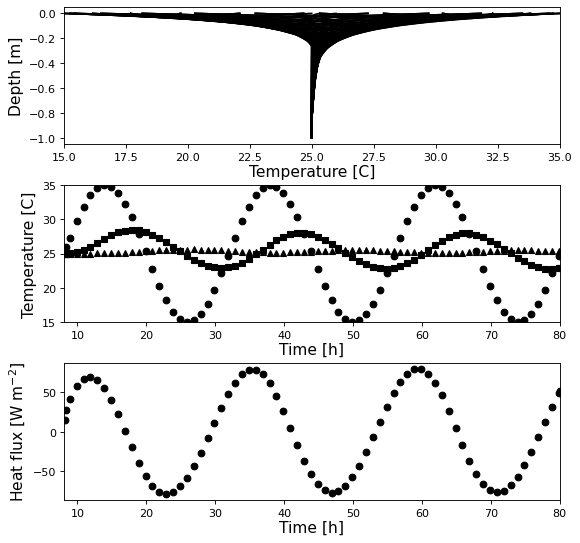

In [14]:
from main2 import main
bulkDensity = 900. # kg/m3
clay = 0.4 # g/g
main(bulkDensity, clay)
# Crank–Nicolson weighting factor=0.5